In [48]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from time import time

# Local descriptors
from skimage.feature import hog
from skimage import  exposure
from skimage import feature


# Transformación de datos
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px


In [54]:
def lbphist(ncellsx, ncellsy, type):
    #Rejilla de histogramas
    pxpercellx = int(width/ncellsx)
    pxpercelly = int(height/ncellsy)

    # Rejillas de igual tamaño y centradas en la imagen de entrada
    ofx = int((width - int(pxpercellx)*ncellsx)/2)
    ofy = int((height - int(pxpercelly)*ncellsy)/2)
    #print('Offset')
    #print(ofx,ofy)

    Xlbp = []

    LBPu_hist = []
    for i in range(0,ncellsy):
        for j in range(0,ncellsx):
            # Extrae celda
            roi=gray[ofy+i*pxpercelly:ofy+(i+1)*pxpercelly,ofx+j*pxpercellx:ofx+(j+1)*pxpercellx]
            # Obtiene imagen LBO
            lbpimg = feature.local_binary_pattern(roi, 8, 1,method=type)
            
            #Obtiene histograma
            n_bins = int(lbpimg.max()) + 1            
            #feath, bins = np.histogram(lbpimg.ravel(), normed=True, bins=n_bins, range=(0,n_bins))
            feath, bins = np.histogram(lbpimg, normed=False, bins=n_bins, range=(0,n_bins))
            
            # Concatena con celdas previas
            LBPu_hist= np.concatenate([LBPu_hist , feath])
            
    return LBPu_hist



def over_sampling(X: np.array, y: np.array) -> tuple:
  sm = SMOTE(random_state = 42)
  return sm.fit_resample(X, y)

In [3]:
def GetPredictions(clf, X_train, X_test, y_train, y_test):
    
    print("Normalization...")
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(X_train)
    test_X = scaler.transform(X_test)

    print("training...")
    t0 = time()
    
    clf = clf.fit(train_X, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(test_X)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

def GetPredictionsandProbs(clf, X_train, X_test, y_train, y_test):
    
    print("Normalization...")
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(X_train)
    test_X = scaler.transform(X_test)

    print("training...")
    t0 = time()
    clf = clf.fit(train_X, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(test_X)
    
    # train and test class probabilities
    ytrain_prob = clf.predict_proba(train_X)
    ytest_prob = clf.predict_proba(test_X)
    
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test, ytrain_prob, ytest_prob

In [4]:
# Localización de los datos
folder = "Database_real_and_fake_face_160x160"

<ipython-input-2-ce9e97e2051d>:25: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  feath, bins = np.histogram(lbpimg, normed=False, bins=n_bins, range=(0,n_bins))


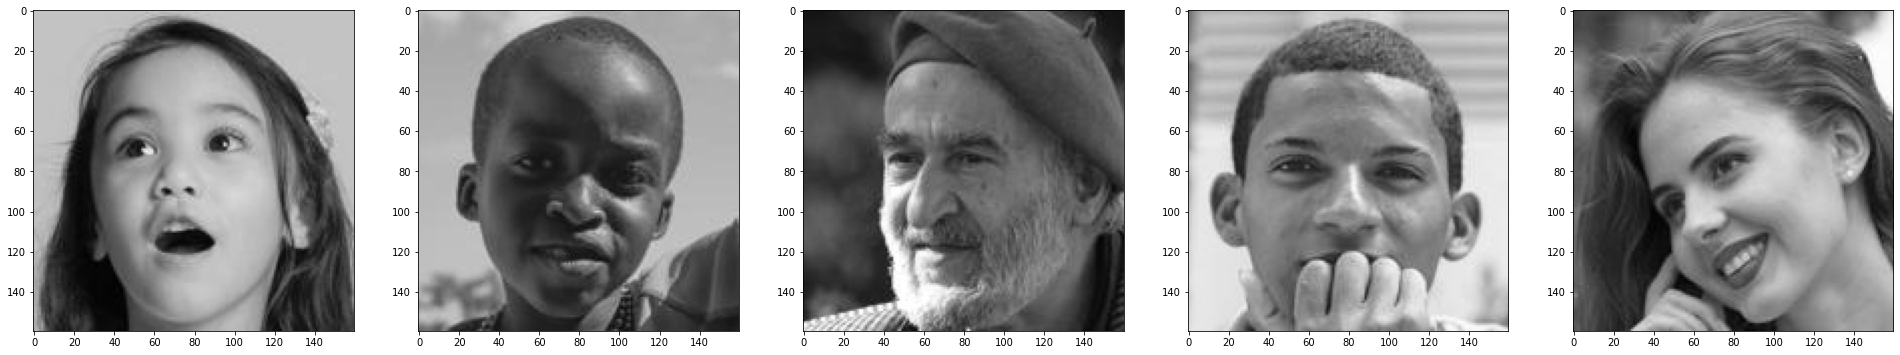

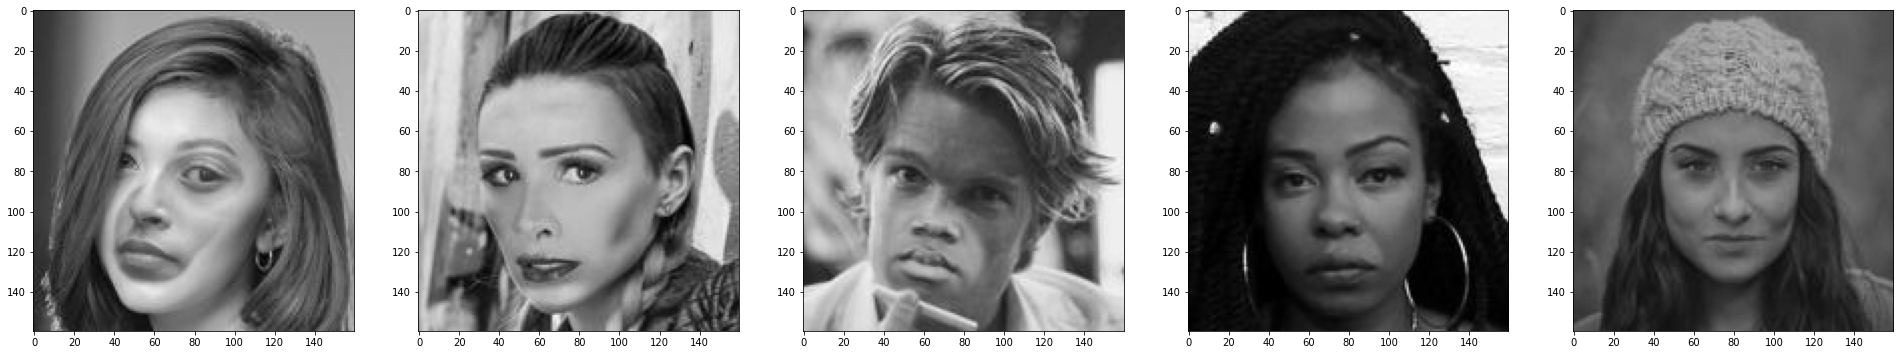

Features
(2041, 25600)
(2041, 32)
(2041, 531)
(2041,)
Dataset info:
# samples: 2041
# features: 25600
# classes: 2
classes ['real', 'fake']
samples per class 1081, 960


In [5]:
# Contador de número de clases del conjunto
nclasses = 0
# Contador de muestras por clase
nperclass = []
# Etiqueta de cada clase (nombre de la subcarpeta)
classlabels = []
# Inicializa estructuras de datos y sus correpondientes etiquetas
X = []
Y = []
Xhog = []
Xlbp = []

# Valor de resolución por defecto de matplotlib
dpi = matplotlib.rcParams['figure.dpi']
# Imágenes de muestra de cada clase a mostrar
nims2show = 5

# HOG
ncellsx = 3
ncellsy = 3

# Asume que en la ruta indicada hay una subcarpeta por clase
for class_name in os.listdir(folder):
    # Cada subcarpeta implica una clase más
    nclasses += 1
    # Inicialmente esta clase no tiene muestras
    nsamples = 0    

    # Compone la ruta
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Asume imágenes en formato jpg
        if file_name.endswith('.jpg'):
            # Lee la imagen
            image = cv2.imread (os.path.join(class_folder, file_name))
            
            # Extrae tamaños
            height, width, depth = image.shape
            # Convierte  grises
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Añade a X, previa conversión en vector
            X.append(gray.reshape(height*width))
            
            # HOG            
            feat_hog, hog_image = hog(gray, orientations=8, pixels_per_cell=(height/ncellsy, width/ncellsx),
                    cells_per_block=(1, 1), visualize=True, multichannel=False, block_norm='L1')
            Xhog.append(feat_hog)
            #print(Xhog.shape)
            
            # LBP
            feat_lbp = lbphist(ncellsx, ncellsy, "nri_uniform") #uniform es también rotation invariant
            Xlbp.append(feat_lbp)
            #print(Xlbp.shape)
            
            # Añade etiqueta numérica de la muestra
            Y.append(nclasses-1)
            
            # Muestra las nims2show primeras muestras de cada clase
            if nsamples < nims2show:
                if nsamples == 0:                    
                    figsize = 15*width / float(dpi), 15*height / float(dpi)
                    fig = plt.figure(figsize=figsize)                
                
                fig.add_subplot(1,nims2show, nsamples + 1)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)                
                
            #Incrementa el número de muestras
            nsamples += 1
    plt.show()
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
#Convierte a numpy array X e Y
X = np.array(X,dtype='float32')
Y = np.array(Y,dtype='float64')
Xhog = np.array(Xhog,dtype='float32')
Xlbp = np.array(Xlbp,dtype='float32')

# Muestra datos del conjunto leído
# Depuración
print("Features")
print(X.shape)
print(Xhog.shape)
print(Xlbp.shape)
#depuración, muestro primera muestra
#print(Xhog[0,:])
#print(Xlbp[0,:])

print(Y.shape)
# Obtiene número de muestras y características
n_samples , n_features = X.shape
# Obtiene nombres de las clases
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

print("Dataset info:")
print("# samples: %d" % n_samples)
print("# features: %d" % n_features)
print("# classes: %d" % n_classes)
print("classes %s" % classlabels)
print("samples per class %s" % str(nperclass)[1:-1] )

In [42]:
# StratifiedKFold
K = 5
skf = StratifiedKFold(n_splits=K, random_state=7, shuffle=True)

fold = 1
for train_index, test_index in skf.split(X, Y):
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    fold += 1

Fold 1
# samples in training set 1632
# samples in test set 409
Fold 2
# samples in training set 1633
# samples in test set 408
Fold 3
# samples in training set 1633
# samples in test set 408
Fold 4
# samples in training set 1633
# samples in test set 408
Fold 5
# samples in training set 1633
# samples in test set 408


In [37]:
def TSNE_plot(data, y, title):
  print(data.shape)
  X_embedded = TSNE(n_components=2).fit_transform(data)
  plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y)
  plt.title(title)
  plt.show()

In [52]:
def kflod_experiment(clf, X, y, name_test):

    print("+++++++++++++++++++++++++++++++++++++++++++\n")

    precs_hog_svm, recs_hog_svm, acc = [], [], []

    fold = 1
    for train_index, test_index in skf.split(X, Y):
        print("*********************\nFold %d" % fold)
        print(name_test)
        y_pred, y_test, hog_train_prob, hog_test_prob = GetPredictionsandProbs(clf, X[train_index], X[test_index], y[train_index], y[test_index])
        print("\n%s Metrics" % name_test)
        precs_hog_svm.append(precision_score(y_test, y_pred))
        recs_hog_svm.append(recall_score(y_test, y_pred))
        acc.append(accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names=class_names))
        if fold == 1:
            print("Confussion matrix:")
            print(confusion_matrix(y_test, y_pred, labels=range(n_classes))) 
        
        fold += 1

    print("\n********K-FOLD SUMMARY*********")
    print(
        "%s Mean Precision:  %0.3f, Mean Recall:  %0.3f, Accuracy: %0.3f" 
        % (name_test, np.mean(precs_hog_svm)*100 , np.mean(recs_hog_svm)*100, np.mean(acc)*100 )) 

(2041, 32)


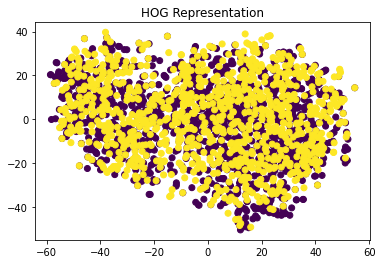

In [38]:
TSNE_plot(Xhog, Y, "HOG Representation")

(2041, 531)


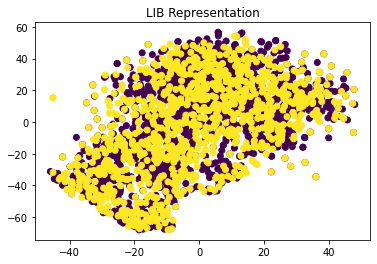

In [53]:
TSNE_plot(Xlbp, Y, "LIB Representation")

# HOG

## Baseline: HOG + SVM

In [50]:
parameters = {'C': [1e3, 5e3], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
# Grid searach across parameter range
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced', probability=True), parameters, cv=5
)

kflod_experiment(clf, Xhog, Y, "HOG + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
HOG + SVM
SVM Normalization...
SVM training...
done in 22.372s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.114s

HOG + SVM Metrics
              precision    recall  f1-score   support

        real       0.59      0.49      0.54       217
        fake       0.52      0.62      0.56       192

    accuracy                           0.55       409
   macro avg       0.55      0.55      0.55       409
weighted avg       0.56      0.55      0.55       409

Confussion matrix:
[[106 111]
 [ 73 119]]
*********************
Fold 2
HOG + SVM
SVM Normalization...
SVM training...
done in 22.984s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01, probability=True)
Predicting
done in 0.112s

HOG + SVM Metrics
              precision    recall  f1-score   support

        real       0.66      0.52      0.58 

## HOG + RF

In [59]:

# Número de árboles
n_estimators=list(range(100,1000,100))
# Maxima profundidad
max_depth = list(range(4,13,4))
# El número mínimo de muestras necesarias para estar en un nodo hoja
min_samples_leaf=[1,2,5,7]
# Número mínimo de muestras necesarias para dividir un nodo interno
min_samples_split=list(range(2,9,2))
# Número de características a considerar en cada división
max_features=['auto','sqrt']


param_grid = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

model = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid,
                           cv = K)


In [56]:
kflod_experiment(model, Xhog, Y, "HOG + RF")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
HOG + RF
SVM Normalization...
SVM training...
done in 78.521s
Best estimator found by grid search:
RandomForestClassifier(max_depth=4, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=6, n_estimators=900)
Predicting
done in 0.281s

HOG + RF Metrics
              precision    recall  f1-score   support

        real       0.58      0.60      0.59       217
        fake       0.53      0.51      0.52       192

    accuracy                           0.56       409
   macro avg       0.55      0.55      0.55       409
weighted avg       0.56      0.56      0.56       409

Confussion matrix:
[[131  86]
 [ 95  97]]
*********************
Fold 2
HOG + RF
SVM Normalization...
SVM training...
done in 76.357s
Best estimator found by grid search:
RandomForestClassifier(max_depth=8, min_samples_leaf=5, min_samples_split=4,
                       n_estimators=800)
Predicting
done in 0.289s

HO

In [69]:
pca = PCA(n_components=0.95)                           
Xhog_pca = pca.fit_transform(Xhog)

print(Xhog_pca.shape)

parameters = {'C': [1e3, 5e3], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
# Grid searach across parameter range
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced', probability=True), parameters, cv=5
)


kflod_experiment(clf, Xhog_pca, Y, "HOG + PCA + SVM")    

(2041, 18)
+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
HOG + PCA + SVM
SVM Normalization...
SVM training...
done in 16.375s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.083s

HOG + PCA + SVM Metrics
              precision    recall  f1-score   support

        real       0.58      0.50      0.53       217
        fake       0.51      0.59      0.55       192

    accuracy                           0.54       409
   macro avg       0.54      0.54      0.54       409
weighted avg       0.55      0.54      0.54       409

Confussion matrix:
[[108 109]
 [ 79 113]]
*********************
Fold 2
HOG + PCA + SVM
SVM Normalization...
SVM training...
done in 16.561s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005, probability=True)
Predicting
done in 0.082s

HOG + PCA + SVM Metrics
              precision    recall  f1-score   support

        

# LIB

In [60]:
parameters = {'C': [1e3, 5e3], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
# Grid searach across parameter range
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced', probability=True), parameters, cv=5
)

kflod_experiment(clf, Xlbp, Y, "LIB + SVM")

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
LIB + SVM
SVM Normalization...
SVM training...
done in 270.299s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 1.933s

LIB + SVM Metrics
              precision    recall  f1-score   support

        real       0.64      0.60      0.62       217
        fake       0.58      0.61      0.60       192

    accuracy                           0.61       409
   macro avg       0.61      0.61      0.61       409
weighted avg       0.61      0.61      0.61       409

Confussion matrix:
[[131  86]
 [ 74 118]]
*********************
Fold 2
LIB + SVM
SVM Normalization...
SVM training...
done in 266.524s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001, probability=True)
Predicting
done in 1.734s

LIB + SVM Metrics
              precision    recall  f1-score   support

        real       0.64      0.53      

In [62]:
# Número de árboles
n_estimators=list(range(100,1000,100))
# Maxima profundidad
max_depth = list(range(4,13,4))
# El número mínimo de muestras necesarias para estar en un nodo hoja
min_samples_leaf=[1,2,5,7]
# Número mínimo de muestras necesarias para dividir un nodo interno
min_samples_split=list(range(2,9,2))
# Número de características a considerar en cada división
max_features=['auto','sqrt']


param_grid = {"n_estimators":n_estimators,
              "max_depth":max_depth,
              "min_samples_split":min_samples_split,
              "min_samples_leaf":min_samples_leaf,
              "max_features":max_features}

model = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid,
                           cv = K)
kflod_experiment(model, Xlbp, Y, "LIB + RF")                           

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
LIB + RF
SVM Normalization...
SVM training...
done in 168.519s
Best estimator found by grid search:
RandomForestClassifier(max_depth=8, max_features='sqrt', min_samples_leaf=7,
                       n_estimators=900)
Predicting
done in 0.351s

LIB + RF Metrics
              precision    recall  f1-score   support

        real       0.60      0.74      0.66       217
        fake       0.60      0.45      0.52       192

    accuracy                           0.60       409
   macro avg       0.60      0.60      0.59       409
weighted avg       0.60      0.60      0.60       409

Confussion matrix:
[[160  57]
 [105  87]]
*********************
Fold 2
LIB + RF
SVM Normalization...
SVM training...
done in 154.205s
Best estimator found by grid search:
RandomForestClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=8,
                       n_estimators=500)
Predicting
done in 0.156s

LIB + RF Metrics
    

In [66]:
model = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid,
                           cv = K)

pca = PCA(n_components=0.95)                           
Xlbp_pca = pca.fit_transform(Xlbp)

print(Xlbp_pca.shape)

kflod_experiment(model, Xlbp, Y, "LIB + RF")    

(2041, 84)
+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1
LIB + RF
SVM Normalization...
SVM training...
done in 147.392s
Best estimator found by grid search:
RandomForestClassifier(max_depth=12, max_features='sqrt', min_samples_leaf=7,
                       min_samples_split=8, n_estimators=800)
Predicting
done in 0.350s

LIB + RF Metrics
              precision    recall  f1-score   support

        real       0.60      0.73      0.66       217
        fake       0.60      0.45      0.51       192

    accuracy                           0.60       409
   macro avg       0.60      0.59      0.59       409
weighted avg       0.60      0.60      0.59       409

Confussion matrix:
[[158  59]
 [105  87]]
*********************
Fold 2
LIB + RF
SVM Normalization...
SVM training...
done in 186.586s
Best estimator found by grid search:
RandomForestClassifier(max_depth=12, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=4, n_estimator